In [11]:
N_CLONES = 2000
DB_PATH = f"../data/synthetic/raw/cld_{N_CLONES}clones.db"

# Notebook 04b - Predicted-late-based Clone Selection (Deployment-style)

## Goal
Simulate a real CLD project setting:
- At selection time, **late outcomes are unknown**
- We select clones using early features + **predicted late outcomes**
- We evaluate the selection using true late outcomes (available only in simulation)

Selection score (deployment-style):
score = w_titer * z(pred_late_titer)
        - w_drop * z(pred_drop)
        - w_agg * z(pred_late_agg)

We compare retain 20% and retain 10%, and optionally true weights by grid search.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load predictions from CSV file

PRED_PATH = "../data/synthetic/processed/predictions_testset_3targets.csv"
df = pd.read_csv(PRED_PATH)
df.head()

,clone_id,true_drop,pred_drop,true_late_titer,pred_late_titer,true_late_agg,pred_late_agg
0,CLONE_0362,0.387063,0.267649,1.555675,1.146125,8.137307,5.344222
1,CLONE_0074,0.335258,0.282072,2.600837,1.164593,2.209127,5.707408
2,CLONE_0375,0.249261,0.256892,0.845235,1.289564,1.484692,5.345388
3,CLONE_0156,0.274382,0.273758,1.098513,1.659863,5.089938,4.716175
4,CLONE_0105,0.249853,0.255309,3.331767,1.404860,5.319159,5.084001


In [8]:
# Utility functions

def zscore(s):
    s = s.astype(float)
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

def retain_top_fraction(df, score_col, fraction, higher_is_better=True, seed=42):
    n = max(1, int(np.ceil(len(df) * fraction)))
    if score_col == "random":
        rng = np.random.default_rng(seed)
        return df.iloc[rng.choice(len(df), size=n, replace=False)].copy()
    ascending = not higher_is_better
    return df.sort_values(score_col, ascending=ascending).head(n).copy()

def summarize_selection(df_sel, stable_cutoff=0.15):
    return {
        "n_selected": len(df_sel),
        "mean_true_drop": df_sel["true_drop"].mean(),
        "stable_rate(true_drop<=0.15)": (df_sel["true_drop"] <= stable_cutoff).mean(),
        "mean_true_late_titer": df_sel["true_late_titer"].mean(),
        "mean_true_late_agg": df_sel["true_late_agg"].mean(),
    }

In [9]:
# Selection experiments

fractions = [0.20, 0.10]

# Fixed weights (start point)
W_TITER, W_DROP, W_AGG = 1.0, 1.0, 0.5

d = df.copy()
d["z_pred_late_titer"] = zscore(d["pred_late_titer"])
d["z_pred_drop"] = zscore(d["pred_drop"])
d["z_pred_late_agg"] = zscore(d["pred_late_agg"])

d["score_pred_late_multi"] = (
    W_TITER * d["z_pred_late_titer"]
    - W_DROP * d["z_pred_drop"]
    - W_AGG * d["z_pred_late_agg"]
)

rows = []
for frac in fractions:
    rows.append({"method": "baseline_random", "retain_frac": frac,
                 **summarize_selection(retain_top_fraction(d, "random", frac, True))})

    # baseline: early-late proxy 없음 -> 여기서는 pred_late_titer로 "titer baseline" 흉내 가능
    rows.append({"method": "baseline_pred_late_titer", "retain_frac": frac,
                 **summarize_selection(retain_top_fraction(d, "pred_late_titer", frac, True))})

    rows.append({"method": "ml_pred_drop_only", "retain_frac": frac,
                 **summarize_selection(retain_top_fraction(d, "pred_drop", frac, False))})

    rows.append({"method": "ml_pred_late_multi", "retain_frac": frac,
                 **summarize_selection(retain_top_fraction(d, "score_pred_late_multi", frac, True))})

results = pd.DataFrame(rows)
results

,method,retain_frac,n_selected,mean_true_drop,stable_rate(true_drop<=0.15),mean_true_late_titer,mean_true_late_agg
0,baseline_random,0.2,20,0.287862,0.05,1.817391,5.565660
1,baseline_pred_late_titer,0.2,20,0.231798,0.25,1.134225,6.013258
2,ml_pred_drop_only,0.2,20,0.257876,0.10,1.320890,5.629384
3,ml_pred_late_multi,0.2,20,0.244115,0.15,1.179427,5.516007
4,baseline_random,0.1,10,0.287545,0.00,1.969772,5.902509
5,baseline_pred_late_titer,0.1,10,0.219870,0.20,1.036382,6.417082
6,ml_pred_drop_only,0.1,10,0.234535,0.10,1.456945,5.832840
7,ml_pred_late_multi,0.1,10,0.246676,0.10,1.432991,5.976658


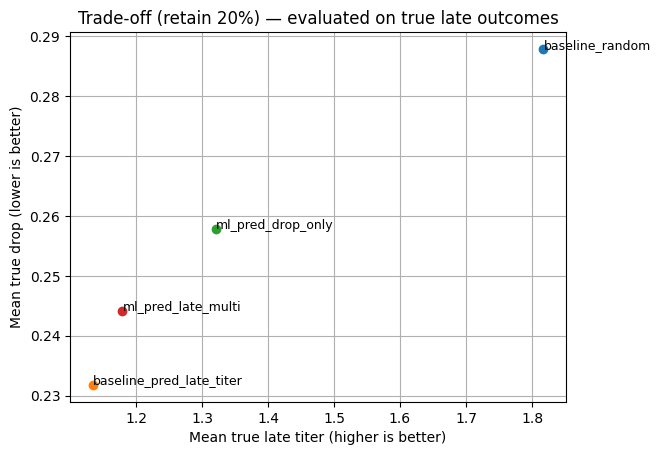

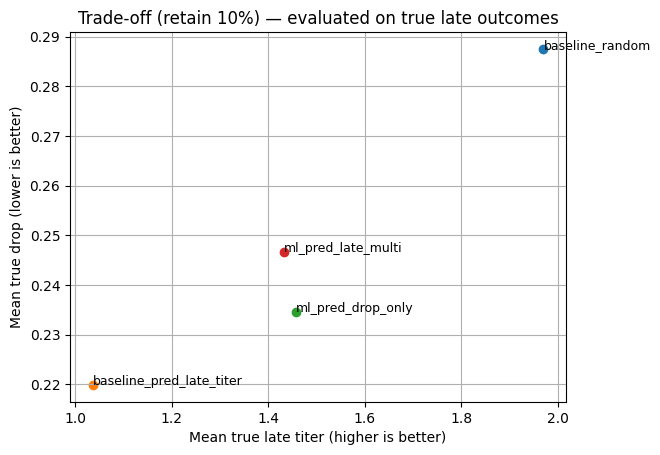

In [10]:
def plot_tradeoff(sub, title):
    plt.figure()
    for _, r in sub.iterrows():
        plt.scatter(r["mean_true_late_titer"], r["mean_true_drop"])
        plt.text(r["mean_true_late_titer"], r["mean_true_drop"], r["method"], fontsize=9)
    plt.title(title)
    plt.xlabel("Mean true late titer (higher is better)")
    plt.ylabel("Mean true drop (lower is better)")
    plt.grid(True)
    plt.show()

for frac in fractions:
    sub = results[results["retain_frac"] == frac].copy()
    plot_tradeoff(sub, f"Trade-off (retain {int(frac*100)}%) — evaluated on true late outcomes")